
DGL at a Glance
=========================


DGL is a Python package dedicated to deep learning on graphs, built atop
existing tensor DL frameworks (e.g. Pytorch, MXNet) and simplifying the
implementation of graph-based neural networks.

The goal of this tutorial:

- Understand how DGL enables computation on graph from a high level.
- Train a simple graph neural network in DGL to classify nodes in a graph.

At the end of this tutorial, we hope you get a brief feeling of how DGL works.

*This tutorial assumes basic familiarity with pytorch.*

Tutorial problem description
----------------------------

The tutorial is based on the <b>"Zachary's karate club"</b> problem. The karate club
is a social network that includes 34 members and documents pairwise links
between members who interact outside the club.  The club later divides into
two communities led by the instructor (node 0) and the club president (node
33). The network is visualized as follows with the color indicating the
community:

![](https://data.dgl.ai/tutorial/img/karate-club.png)

The task is to predict which side (0 or 33) each member tends to join given
the social network itself.

In [24]:
import dgl
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
import networkx as nx

In [25]:
node_count = 34

In [26]:
# Load from pickle file

with open('edge_list.pickle', 'rb') as f:
    edge_list = pickle.load(f)

In [27]:
print(edge_list)

[('0', '8'), ('1', '17'), ('24', '31'), ('13', '33'), ('0', '1'), ('2', '8'), ('0', '19'), ('25', '31'), ('14', '33'), ('0', '2'), ('2', '9'), ('1', '19'), ('28', '31'), ('15', '33'), ('1', '2'), ('0', '10'), ('0', '21'), ('2', '32'), ('18', '33'), ('0', '3'), ('4', '10'), ('1', '21'), ('8', '32'), ('19', '33'), ('1', '3'), ('5', '10'), ('23', '25'), ('14', '32'), ('20', '33'), ('2', '3'), ('0', '11'), ('24', '25'), ('15', '32'), ('22', '33'), ('0', '4'), ('0', '12'), ('2', '27'), ('18', '32'), ('23', '33'), ('0', '5'), ('3', '12'), ('23', '27'), ('20', '32'), ('26', '33'), ('0', '6'), ('0', '13'), ('24', '27'), ('22', '32'), ('27', '33'), ('4', '6'), ('1', '13'), ('2', '28'), ('23', '32'), ('28', '33'), ('5', '6'), ('2', '13'), ('23', '29'), ('29', '32'), ('29', '33'), ('0', '7'), ('3', '13'), ('26', '29'), ('30', '32'), ('30', '33'), ('1', '7'), ('5', '16'), ('1', '30'), ('31', '32'), ('31', '33'), ('2', '7'), ('6', '16'), ('8', '30'), ('8', '33'), ('32', '33'), ('3', '7'), ('0', '17

In [28]:
def build_karate_club_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(node_count)
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    return g

In [29]:
G = build_karate_club_graph(edge_list)

In [30]:
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


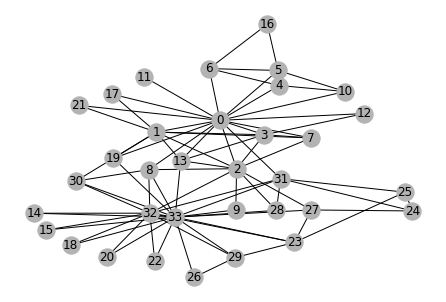

In [31]:
# Since the actual graph is undirected, we convert it for visualization purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [33]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        h = self.softmax(h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

In [34]:
inputs = torch.eye(node_count)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0,1])  # their labels are different

In [41]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
all_preds = []
epochs = 30

for epoch in range(epochs):
    preds = net(G, inputs)
    all_preds.append(preds)
#     print(all_preds)
#     print(labels)
    # we only compute loss for labeled nodes
    loss = F.cross_entropy(preds[labeled_nodes], labels)

    optimizer.zero_grad() # PyTorch accumulates gradients by default
    loss.backward() 
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

C:\Users\M1054427\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch 0 | Loss: 0.3133
Epoch 1 | Loss: 0.3133
Epoch 2 | Loss: 0.3133
Epoch 3 | Loss: 0.3133
Epoch 4 | Loss: 0.3133
Epoch 5 | Loss: 0.3133
Epoch 6 | Loss: 0.3133
Epoch 7 | Loss: 0.3133
Epoch 8 | Loss: 0.3133
Epoch 9 | Loss: 0.3133
Epoch 10 | Loss: 0.3133
Epoch 11 | Loss: 0.3133
Epoch 12 | Loss: 0.3133
Epoch 13 | Loss: 0.3133
Epoch 14 | Loss: 0.3133
Epoch 15 | Loss: 0.3133
Epoch 16 | Loss: 0.3133
Epoch 17 | Loss: 0.3133
Epoch 18 | Loss: 0.3133
Epoch 19 | Loss: 0.3133
Epoch 20 | Loss: 0.3133
Epoch 21 | Loss: 0.3133
Epoch 22 | Loss: 0.3133
Epoch 23 | Loss: 0.3133
Epoch 24 | Loss: 0.3133
Epoch 25 | Loss: 0.3133
Epoch 26 | Loss: 0.3133
Epoch 27 | Loss: 0.3133
Epoch 28 | Loss: 0.3133
Epoch 29 | Loss: 0.3133


In [36]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'c', 'r')

print(predicted_class)
print(color)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
['c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'r' 'r' 'c' 'c' 'c' 'c' 'r' 'r' 'c' 'c'
 'r' 'c' 'r' 'c' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r']


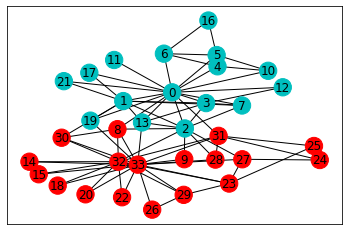

In [37]:
nx.draw_networkx(nx_G, pos, node_color=color, with_labels=True, node_size=300)

In [38]:
print(last_epoch[8])

[4.0647254e-04 9.9959356e-01]
